In [2]:
import os

dataset_dir = r"D:/harmful content/archive (3)/violence_dataset/"

print(os.listdir(dataset_dir))


['non_violence', 'violence']


In [3]:
# Install required packages (only first time)
!pip install tensorflow matplotlib

# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Path to your dataset
dataset_dir = r"D:/harmful content/archive (3)/violence_dataset/"


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 8851 images belonging to 2 classes.
Found 2212 images belonging to 2 classes.


In [6]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze feature extractor

# Build full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


Epoch 1/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.9335 - loss: 0.1623 - val_accuracy: 0.8865 - val_loss: 0.2704
Epoch 2/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.9398 - loss: 0.1485 - val_accuracy: 0.8870 - val_loss: 0.2572
Epoch 3/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9422 - loss: 0.1374 - val_accuracy: 0.8897 - val_loss: 0.2692
Epoch 4/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.9424 - loss: 0.1281 - val_accuracy: 0.9073 - val_loss: 0.2315
Epoch 5/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9519 - loss: 0.1197 - val_accuracy: 0.8947 - val_loss: 0.2448


In [13]:
model.save("violence_detection_model.h5")


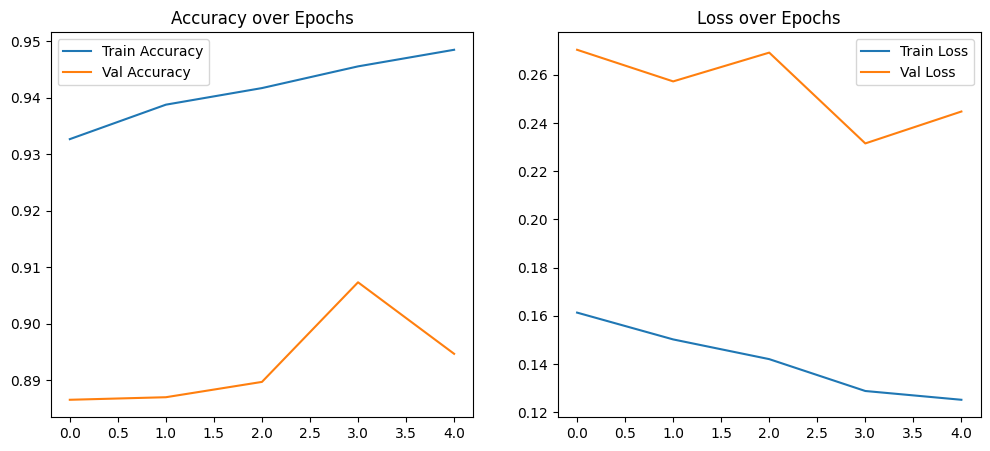

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load trained model
model = tf.keras.models.load_model("violence_detection_model.h5")

# MobileNetV2 expects 224x224 input
IMAGE_SIZE = (224, 224)

def prevent_image_upload(img_path):
    """Check if image is harmful or safe using trained model"""
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array, verbose=0)

    # Some models output shape (1,1), others (1,2) for softmax
    if pred.shape[-1] == 1:  
        score = pred[0][0]
    else:  # softmax with 2 classes
        score = pred[0][1]  # probability of "harmful"

    print(f"Prediction score: {score:.4f}")  # Debugging log

    return score < 0.5   # Return True if safe, False if harmful


def upload_and_check():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg")])
    if not file_path:
        return
    
    allowed = prevent_image_upload(file_path)
    
    if allowed:
        messagebox.showinfo("Result", "✅ Safe image. Upload Allowed.")
    else:
        messagebox.showwarning("Blocked", "❌ Harmful Image Detected. Upload Blocked!")


# Tkinter GUI
root = tk.Tk()
root.title("Image Upload Prevention System")

btn = tk.Button(root, text="Upload Image", command=upload_and_check, width=25, height=2)
btn.pack(pady=20)

root.mainloop()


Prediction score: 0.7820
Prediction score: 0.0208
